<h1><center>Federated Learning-Based Naive Bayes Model for Detecting Suicide Decision</center></h1>

According to research[[Link]](https://www.kaggle.com/code/rutujapotdar/suicide-text-classification-nlp) on suicide-watch dataset[[Link]](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch), five models are tested on dataset. These models are as follow:
* Naive Bayes (Voting Classifier)
* Random Forest
* Decision Tree
* Gradient Boosting
* XG Boost

At the end, Naive Bayes is choosen as best models on this dataset. As you know, in many psychological counseling institutions and clinics, the information recorded in patient chats and interviews is confidential and cannot be made available to the public. Therefore, the use of cryptographic protocols in analyzing and interpreting this information is of great importance.

In this notebook I impliment a Federated Learning-Based Naive Bayes Model for Detecting Suicide Decision on suicide-watch dataset.

### Important liberaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer

### Loading dataset and EDA

In [2]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("nikhileswarkomati/suicide-watch")
print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/Suicide_Detection.csv")

df.head()

Path to dataset files: /kaggle/input/suicide-watch


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
df['Unnamed: 0'].is_unique
df.drop(columns = 'Unnamed: 0',inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


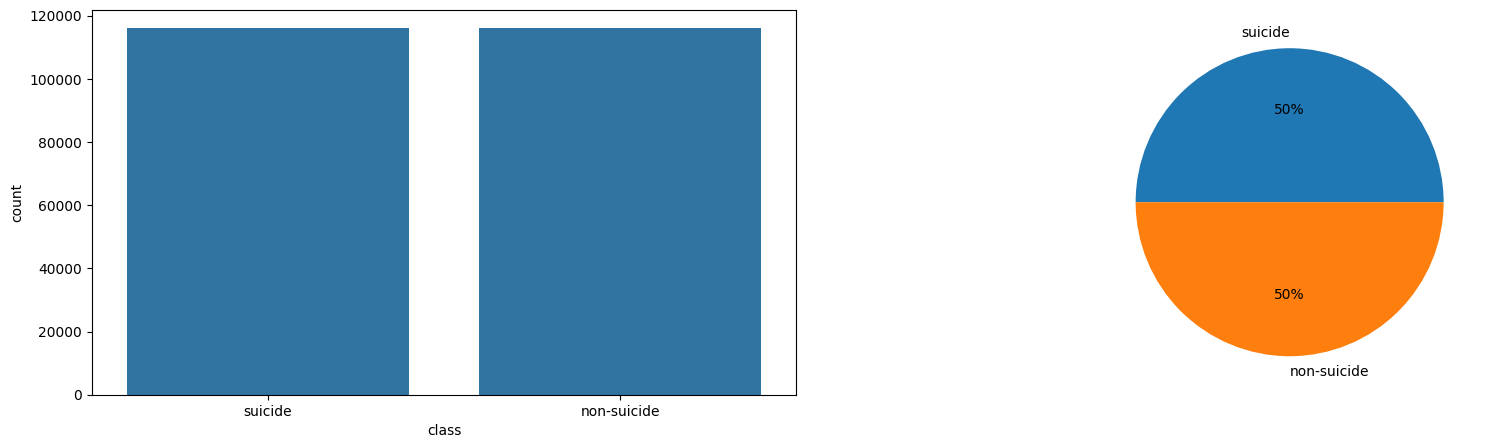

In [4]:
classCnt = df['class'].value_counts()
print(classCnt)

plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
sns.countplot(df,x='class')

plt.subplot(1,2,2)
plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

plt.show()

### Preproccess

In [5]:
df['text']= df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)
df.head()

,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i dont get affected by compliments ...,non-suicide
2,finally 2020 is almost over so i can never hea...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,im so losthello my name is adam 16 and ive bee...,suicide


In [6]:
# Saved the cleaned dataset.
df.to_csv('file1.csv')
dfnew = pd.read_csv('file1.csv')
dfnew.head()

,Unnamed: 0,text,class
0,0,ex wife threatening suiciderecently i left my ...,suicide
1,1,am i weird i dont get affected by compliments ...,non-suicide
2,2,finally 2020 is almost over so i can never hea...,non-suicide
3,3,i need helpjust help me im crying so hard,suicide
4,4,im so losthello my name is adam 16 and ive bee...,suicide


In [7]:
ind = dfnew[dfnew['text'].isnull()].index

In [8]:
df.iloc[ind]

,text,class
21188,,suicide
137872,,suicide
204433,,suicide
210846,,suicide


In [9]:
dfnew.dropna(inplace=True)

### Naive Bayes Model

In [10]:
X,y = dfnew['text'],dfnew['class']
vectorizer = TfidfVectorizer(min_df=50,max_features=1000)
x_vectorized =  vectorizer.fit_transform(X).toarray()
# Save the model
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
X_train,X_test,y_train,y_test = train_test_split(x_vectorized,y,test_size=0.30,random_state=5)
X_train.shape,X_test.shape

((162449, 1000), (69621, 1000))

In [11]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.880208557762744
Testing score: 0.880653825713506


              precision    recall  f1-score   support

 non-suicide       0.90      0.85      0.88     34726
     suicide       0.86      0.91      0.88     34895

    accuracy                           0.88     69621
   macro avg       0.88      0.88      0.88     69621
weighted avg       0.88      0.88      0.88     69621



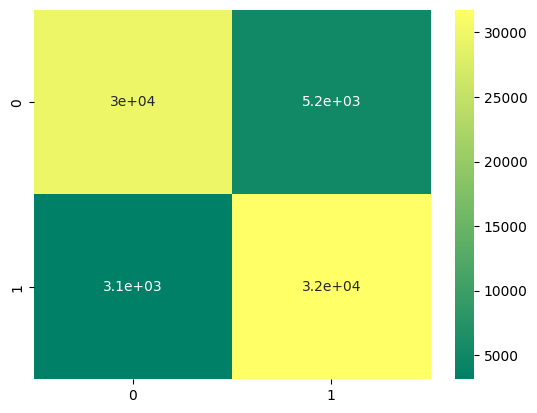

In [12]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

### Federated Learning-Based Naive Bayes Model

In [13]:
# --- Simulate Federated Clients ---
y = dfnew['class'].apply(lambda x: 1 if x == 'suicide' else 0)  # suicide:1, non-suicide:0

n_clients = 20
client_data_size = len(X) // n_clients
clients_X, clients_y = [], []

for i in range(n_clients):
    start = i * client_data_size
    end = (i + 1) * client_data_size if i < n_clients - 1 else len(X)
    clients_X.append(x_vectorized[start:end])
    clients_y.append(y[start:end].values)

In [14]:
# --- Train VotingClassifier on each client ---
ensemble_models = []

for i in range(n_clients):
    X_train, X_test_local, y_train, y_test_local = train_test_split(clients_X[i], clients_y[i], test_size=0.3, random_state=5)

    nb = GaussianNB()
    nb2 = BernoulliNB()
    nb3 = MultinomialNB()

    VotingClassifiers = VotingClassifier(
        estimators=[
            ('GaussianNB', nb),
            ('BernoulliNB', nb2),
            ('MultinomialNB', nb3)],
        voting='soft'
    )

    try:
        VotingClassifiers.fit(X_train, y_train)
        ensemble_models.append(VotingClassifiers)
    except Exception as e:
        print(f"Client {i} failed training: {e}")

In [15]:
# --- Aggregate predictions ---
X_train_full, X_test, y_train_full, y_test = train_test_split(x_vectorized, y, test_size=0.3, random_state=5)

In [16]:
# Collect predictions from each model and average them
all_probs = []
for model in ensemble_models:
    try:
        proba = model.predict_proba(X_test)
        all_probs.append(proba)
    except Exception as e:
        print(f"Prediction failed: {e}")

In [17]:
# Average probabilities
avg_proba = np.mean(all_probs, axis=0)
y_pred = np.argmax(avg_proba, axis=1)

Testing score: 0.8853506844199308


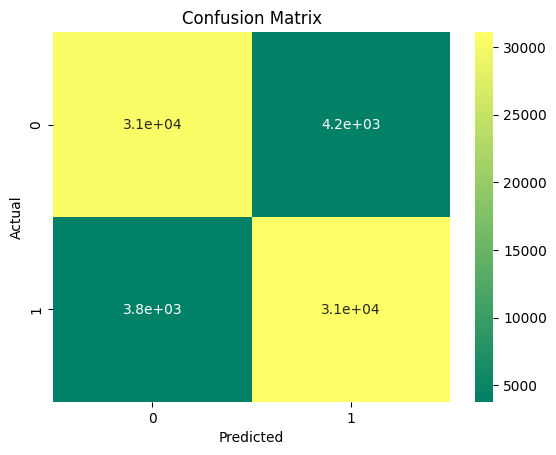

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     34726
           1       0.88      0.89      0.89     34895

    accuracy                           0.89     69621
   macro avg       0.89      0.89      0.89     69621
weighted avg       0.89      0.89      0.89     69621



In [18]:
# --- Evaluation ---
print("Testing score:", np.mean(y_pred == y_test))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='summer')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, y_pred))